In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./_A_embeddings/A00_setup.py").load_module()

# SHAP Plots
For the SHAP samples generated in A20, create some plots

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pathlib import Path
import importlib, pickle

In [4]:
import matplotlib.pyplot as plt
from sba_nn.sba_nn import sbnn_plot, sbnn_embed
import matplotlib.ticker as ticker
import textwrap

In [5]:
import seaborn as sns

In [6]:
sbnn_plot.plot_defaults()

## Data, Sources

##### SHAP value data location
Create an output folder

In [7]:
input_shap_path = Path(setup.temp_path).joinpath('A20_SHAP_data')

In [8]:
output_shap_path = Path(setup.temp_path).joinpath('A21_SHAP_plots')
output_shap_path.mkdir(exist_ok = True)

##### Model info

In [9]:
model_info = pd.read_csv(Path(setup.temp_path).joinpath('A10_REPORT_model_info.csv'))
model_info

,model,model_path,model_hier,model_rand,model_layer_name
0,03,../data/2024_05_16/03_DATA_model.keras,False,False,NAICS
1,11,../data/2024_05_16/11_DATA_model.keras,False,True,NAICS
2,04,../data/2024_05_16/04_DATA_model.keras,True,False,NAICS
3,12,../data/2024_05_16/12_DATA_model.keras,True,True,NAICS
4,A01,../data/2024_06_04/A01_DATA_model.keras,True,True,embedding_int
5,A02,../data/2024_06_04/A02_DATA_model.keras,True,False,embedding_int


##### Feature info

In [10]:
with open(Path(setup.parent_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [11]:
# NAICS feature 
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_orig = [c + '_orig' for c in features_naics]

##### NAICS / TSNE summary

In [12]:
tsne_naics_all = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_embed_tsne.parquet'))

## Functions For Analyzing SHAP vs. other

##### Data load

In [13]:
def load_shap_data(input_path, glob_str):
    # filenames
    sel_dict = {m:[f for f in input_path.glob(f'{m}*' + glob_str)][0] 
                    for m in model_info['model'].to_list()}
    return pd.concat([pd.read_parquet(sel_dict[m])
                        for m in sel_dict.keys()],
                       keys=sel_dict.keys()) \
        .reset_index(level=0) \
        .rename(columns={'level_0':'model'}) \
        .reset_index(drop=True)

##### Data wide to long format

In [14]:
def shap_wide_to_long(data, features_numeric = features_numeric,
                     naics_prefix = 'NAICS_emb'):

    shap_features = features_numeric + [c for c in data.columns if c.startswith(naics_prefix)]
    data_long = data \
        .melt(id_vars=['model','LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS_orig'],
              value_vars = shap_features) \
        .dropna()
    data_long['value_abs'] = np.abs(data_long['value'])
    data_long['variable_NAICS'] = np.where(data_long['variable'] \
                                           .str.startswith('NAICS_emb'), 
                                           'NAICS features', 'other features')
    return data_long

##### Aggregate data by NAICS vs other

In [15]:
def shap_naics_other_data(data,
                         group_var = ['model', 'variable_NAICS','dset_naics_holdout']):
    data_1 = data \
        .groupby(group_var + ['LoanNr_ChkDgt']) \
        ['value'] \
        .agg('sum') \
        .reset_index()
    data_1['value_abs'] = np.abs(data_1['value'])
    data_2 = data_1 \
        .groupby(group_var) \
        [['value_abs', 'value']] \
        .agg('mean') \
        .reset_index() \
        .sort_values(['model', 'value_abs'], ascending=[True, False])
    return data_2

## Overall Importances Plot
Get overall importance for each model (all features). Use the randomly selected test NAICS

In [16]:
random_data = load_shap_data(input_shap_path, 'random_shap_values.parquet')

In [17]:
random_data_long = shap_wide_to_long(random_data)

In [18]:
random_data_long.to_parquet(Path(setup.temp_path).joinpath('A21_DATA_shap_long_random.parquet'))

In [45]:
random_data_long.columns

Index(['model', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS_orig',
       'variable', 'value', 'value_abs', 'variable_NAICS'],
      dtype='object')

In [19]:
random_data_imp = random_data_long.groupby(['model', 'variable', 'variable_NAICS']) \
    ['value_abs'] \
    .agg('mean') \
    .reset_index() \
    .sort_values(['model', 'value_abs'], ascending=[True, False])

In [53]:
# group all NAICS together to make plot nicer
random_data_imp_naics_1 = random_data_long[random_data_long['variable_NAICS'] == 'NAICS features'] \
    .groupby(['model', 'LoanNr_ChkDgt']) \
    ['value'] \
    .agg('sum') \
    .reset_index() 
random_data_imp_naics_1['value_abs'] = np.abs(random_data_imp_naics_1['value'])
random_data_imp_naics =  random_data_imp_naics_1 \
    .groupby(['model']) \
    ['value_abs'] \
    .agg('mean') \
    .reset_index() 
random_data_imp_naics['variable'] = 'NAICS'

In [54]:

random_data_imp_grp = pd.concat([random_data_imp[random_data_imp['variable_NAICS'] == 'other features'],
                                                 random_data_imp_naics])
    

In [55]:
model_pairs = [['03', '11'],
               ['04', '12'],
               ['A02', 'A01']]

In [56]:
rand_map = model_info.set_index('model')['model_rand'].to_dict()
rand_map

{'03': False, '11': True, '04': False, '12': True, 'A01': True, 'A02': False}

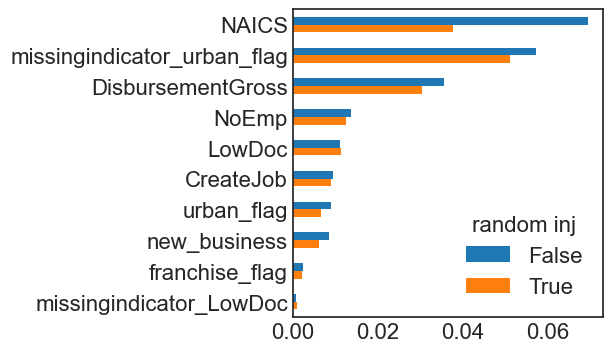

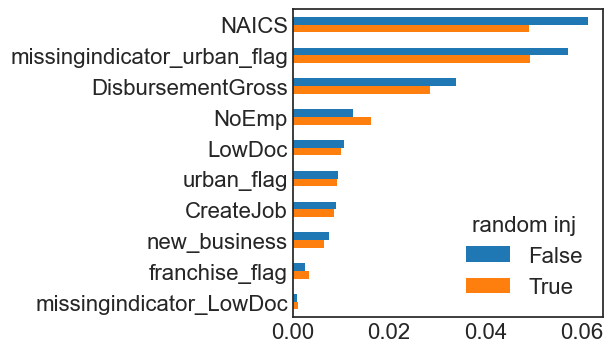

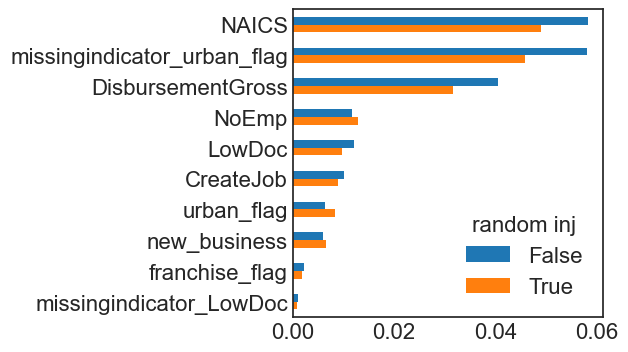

In [57]:
for pair in model_pairs:
    fig, ax=plt.subplots(figsize=(4,4))
    this_data = random_data_imp_grp[random_data_imp_grp['model'].isin(pair)] \
        .sort_values('value_abs', ascending=False) \
        .copy()
    this_data['rand'] = this_data['model'].apply(lambda x: rand_map[x]) 
    sbnn_plot.barh_top_n_pair(this_data, columns='rand',
                             legend_title='random inj', ax=ax)
    fig.savefig(output_shap_path.joinpath('A21_PLOT_overall_imp_' + '_'.join(pair) + '.png'))

## NAICS vs. non-NAICS importance 
By holdout status

In [25]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

In [26]:
random_data_imp_naics = shap_naics_other_data(random_data_long)

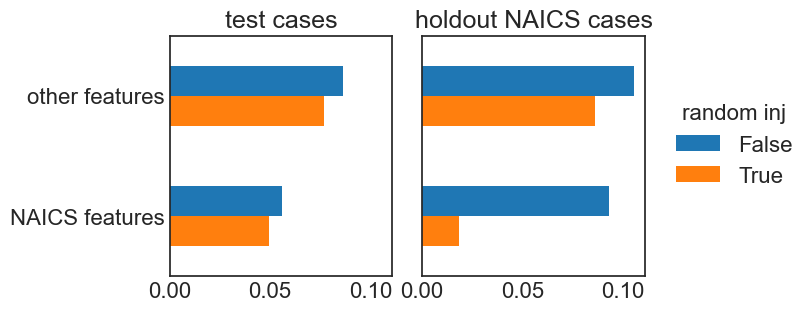

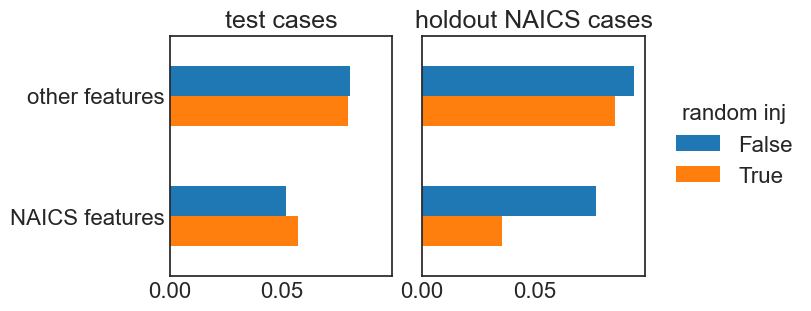

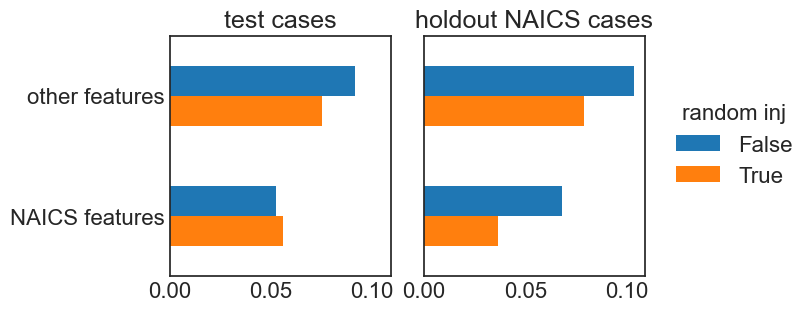

In [27]:
for pair in model_pairs:
    fig, ax=plt.subplots(1, 2, figsize=(8,3),
                        layout='constrained', sharex=True, sharey=True)
    data_1 = random_data_imp_naics[(random_data_imp_naics['model'].isin(pair)) &
                                  (random_data_imp_naics['dset_naics_holdout'] == 0)] \
        .sort_values('value_abs', ascending=False) \
        .copy()
    data_1['rand'] = data_1['model'].apply(lambda x: rand_map[x]) 
    sbnn_plot.barh_top_n_pair(data_1, columns='rand', x='variable_NAICS',
                             legend_title='random inj', ax=ax[0],
                             title='test cases',
                                x_order = ['other features','NAICS features'],)
    data_2 = random_data_imp_naics[(random_data_imp_naics['model'].isin(pair))&
                                  (random_data_imp_naics['dset_naics_holdout'] == 1)] \
        .sort_values('value_abs', ascending=False) \
        .copy()
    ax[0].get_legend().remove()
    data_2['rand'] = data_2['model'].apply(lambda x: rand_map[x]) 
    sbnn_plot.barh_top_n_pair(data_2, columns='rand', x='variable_NAICS',
                             legend_title='random inj', ax=ax[1],
                             title='holdout NAICS cases',
                               x_order = ['other features','NAICS features'])
    ax[1].legend(bbox_to_anchor=(1.05, 0.8), title='random inj')
    fig.savefig(output_shap_path.joinpath('A21_PLOT_naics_imp_' + '_'.join(pair) + '.png'))

## TSNE Plots
Colored by SHAP values.  Ignore the nullified ones now.  Use the selected SHAP values for TSNE plots

##### Load data, make long format

In [28]:
shap_sel_data = load_shap_data(input_shap_path, 'naics_samp_shap_values.parquet')
shap_sel_long = shap_wide_to_long(shap_sel_data)
shap_sel_long.to_parquet(Path(setup.temp_path).joinpath('A21_DATA_shap_long_sel.parquet'))

##### Aggregate SHAP vs other features, join TSNE data

In [29]:
shap_sel_shap_voth = shap_naics_other_data(shap_sel_long,
                         group_var = ['model', 'variable_NAICS','dset_naics_holdout', 'NAICS_orig'])

In [30]:
tsne_naics_shap = tsne_naics_all[['model', 'NAICS_orig', 'tsne_0', 'tsne_1',
                                 'NAICS_sector_orig', 'target_thresh']] \
    .merge(shap_sel_shap_voth, on=['model', 'NAICS_orig'])

In [31]:
tsne_naics_shap.sample(3)

,model,NAICS_orig,tsne_0,tsne_1,NAICS_sector_orig,target_thresh,variable_NAICS,dset_naics_holdout,value_abs,value
3266,A02,621210,-50.886112,-0.145420,62,0.040046,NAICS features,0.0,0.126858,-0.126858
2158,12,621420,-8.784648,25.280996,62,0.173333,other features,1.0,0.064948,0.022841
1561,11,561710,-3.109293,7.098581,56,0.213650,NAICS features,0.0,0.013783,-0.013783


##### Plot NAICS, non-NAICS distribution

In [32]:
xlim_dict= {model:[-70,70] if model in ['03', '11', '04', '12'] else [-65,55]
           for model in model_info['model'].to_list()}

In [33]:
ylim_dict= {model:[-30, 40] if model in ['03', '11', '04', '12'] else [-40, 40]
           for model in model_info['model'].to_list()}

In [34]:
mod_info_sort = model_info.sort_values(['model_layer_name', 'model_hier', 'model_rand'],
                         ascending=[True, True, True])

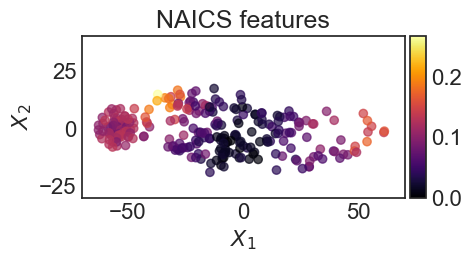

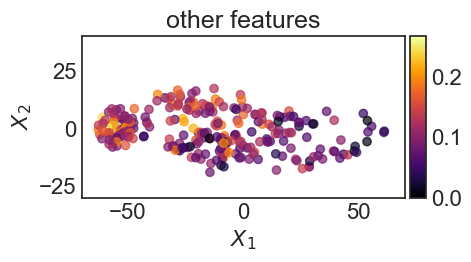

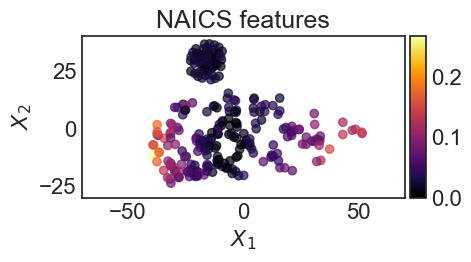

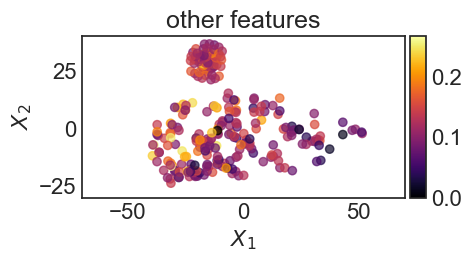

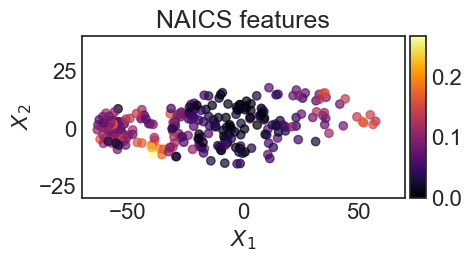

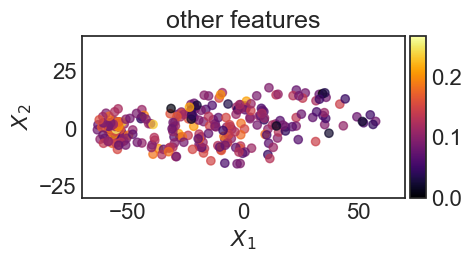

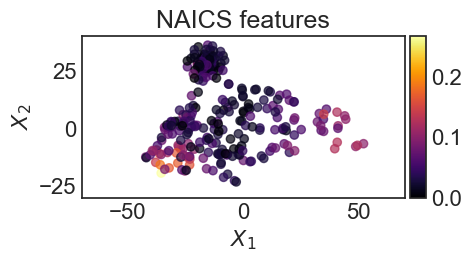

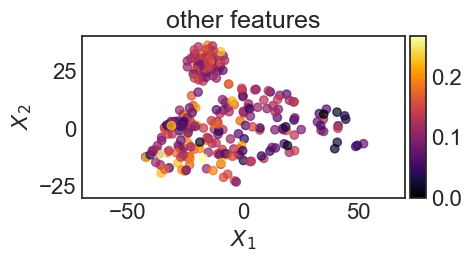

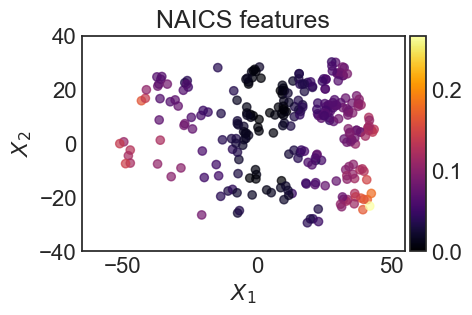

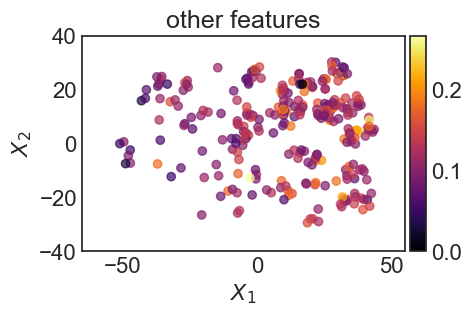

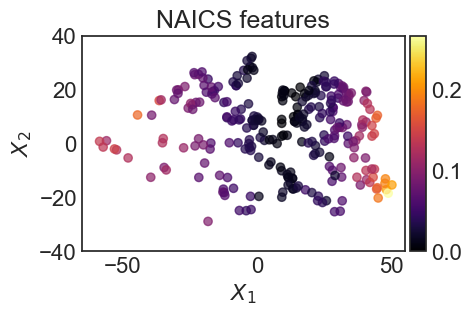

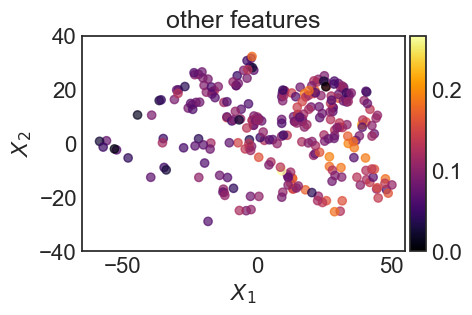

In [35]:
for i, row in mod_info_sort.iterrows():

    model = row['model']
    model_tsne = tsne_naics_shap[tsne_naics_shap['model'] == model]
    cbar_max = tsne_naics_shap['value_abs'].max() *1.001
    for naics_type in ['NAICS features', 'other features']:
        this_tsne = model_tsne[model_tsne['variable_NAICS'] == naics_type]
        this_prefix = f"A21_PLOT_tsne_shap_abs_{i:03d}_m_{model}_" + \
            f"{row['model_layer_name'][0:5]}_{row['model_hier']}" + \
            f"_{row['model_rand']}_" + \
            f"{naics_type.split(' ')[0]}"
        
        sbnn_embed.emb_color_plot(this_tsne, 'value_abs',
                                  cmap=plt.get_cmap('inferno'),
                                  xlim =xlim_dict[model],
                                  ylim=ylim_dict[model],
                                 title_str = naics_type,
                                 title_str_2=None,
                                  colorbar_lim = [0,cbar_max],
                                 figsize = (5, 5),
                                  outfile_folder = Path(setup.temp_path),
                                  outfile_prefix = this_prefix,
                                 holdout_var = None)

##### Same plot, but signed value

In [36]:
cmap = sns.diverging_palette(255, 0, s=200, l=50, sep=20,
                             center="dark", as_cmap=True)

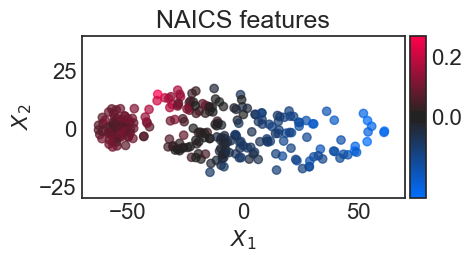

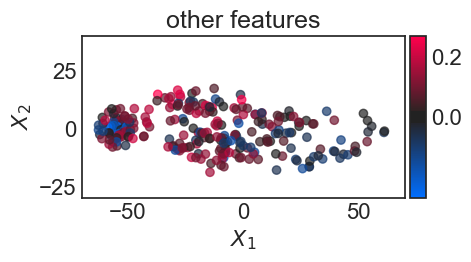

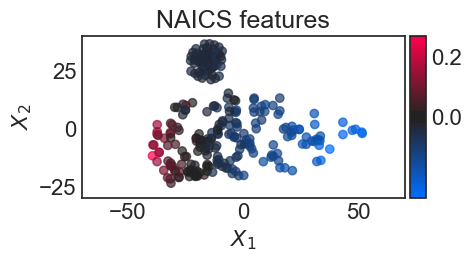

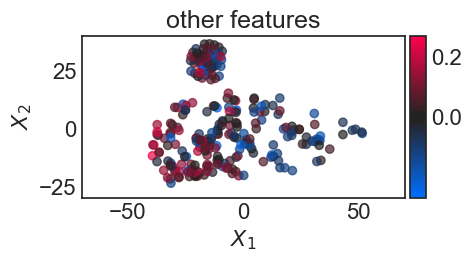

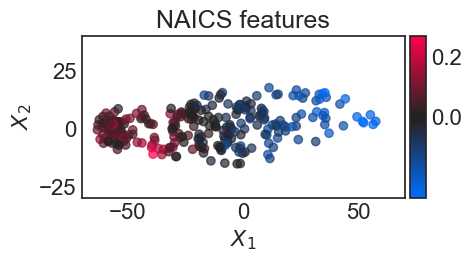

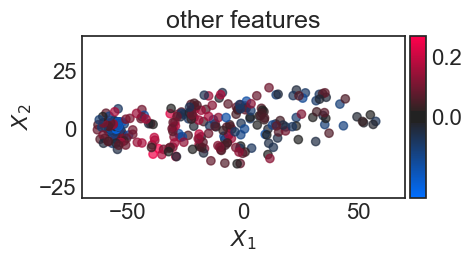

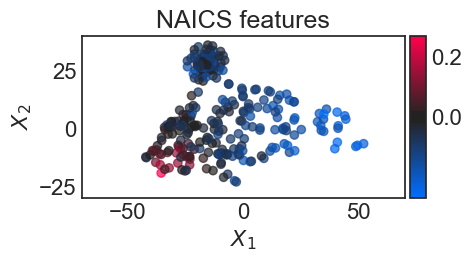

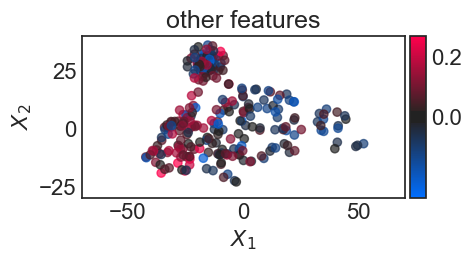

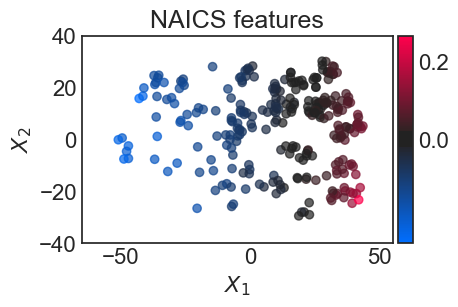

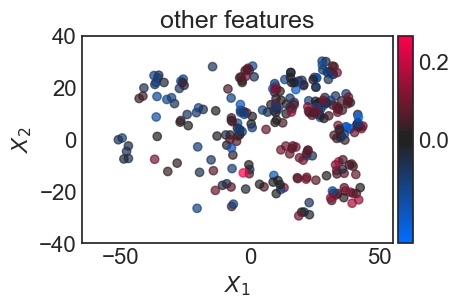

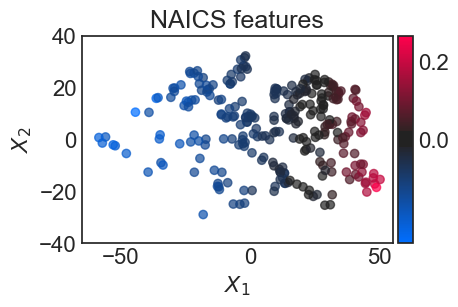

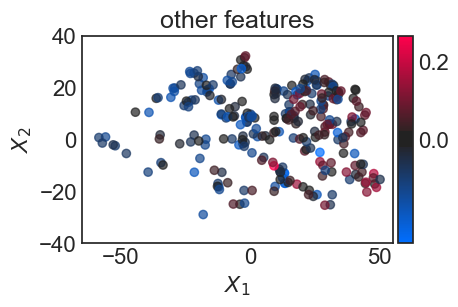

In [37]:
for i, row in mod_info_sort.iterrows():
    model = row['model']
    model_tsne = tsne_naics_shap[tsne_naics_shap['model'] == model]
    cbar_min = tsne_naics_shap['value'].min()* 1.001
    cbar_max = tsne_naics_shap['value'].max()* 1.001
    for naics_type in ['NAICS features', 'other features']:
        
        this_tsne = model_tsne[model_tsne['variable_NAICS'] == naics_type]
        this_prefix = f"A21_PLOT_tsne_shap_raw_{i:03d}_m_{model}_" + \
            f"{row['model_layer_name'][0:5]}_{row['model_hier']}" + \
            f"_{row['model_rand']}_" + \
            f"{naics_type.split(' ')[0]}"
        sbnn_embed.emb_color_plot(this_tsne, 'value', #cmap=plt.get_cmap('RdYlBu_r'), 
                                  cmap = cmap,
                                  xlim =xlim_dict[model],
                                  ylim=ylim_dict[model],
                                 title_str = naics_type,
                                 title_str_2=None,
                                  colorbar_lim = [cbar_min, 0, cbar_max],
                                 figsize = (5, 5),
                                  outfile_folder = Path(setup.temp_path),
                                  outfile_prefix = this_prefix,
                                 holdout_var = None)

## Null NAICS analysis

For data with nullified features, bar plot to compare SHAP for NAICS vs other

##### Import data

In [38]:
shap_null_data = load_shap_data(input_shap_path, 'naics_null_shap_values.parquet')
shap_null_long= shap_wide_to_long(shap_null_data)

In [39]:
shap_null_shap_voth = shap_naics_other_data(shap_null_long,
                         group_var = ['model', 'variable_NAICS','dset_naics_holdout'])

In [40]:
data_test= shap_null_shap_voth[shap_null_shap_voth['dset_naics_holdout'] == 0] \
    .sort_values(['model', 'variable_NAICS']).copy()
data_test['rand'] = data_test['model'].apply(lambda x: rand_map[x]) 

In [41]:
model_pairs

[['03', '11'], ['04', '12'], ['A02', 'A01']]

In [42]:
shap_null_shap_voth[shap_null_shap_voth['model'] == '04']

,model,variable_NAICS,dset_naics_holdout,value_abs,value
7,04,other features,1.0,0.099629,-0.018990
4,04,NAICS features,0.0,0.099333,0.099333
5,04,NAICS features,1.0,0.097614,0.097614
6,04,other features,0.0,0.096918,-0.014617


In [43]:
data_holdout = shap_null_shap_voth[shap_null_shap_voth['dset_naics_holdout'] == 1] \
    .sort_values(['model', 'variable_NAICS']).copy()
data_holdout['rand'] = data_holdout['model'].apply(lambda x: rand_map[x]) 

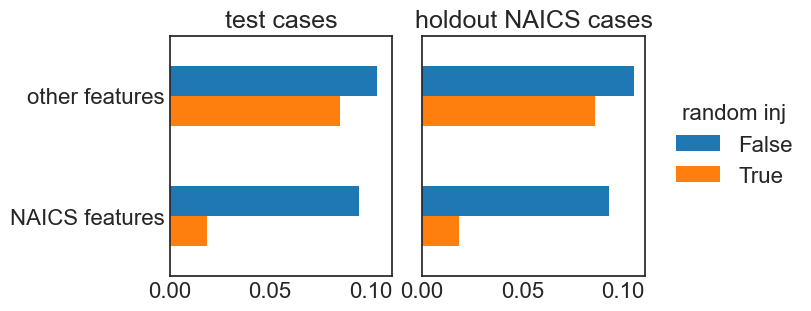

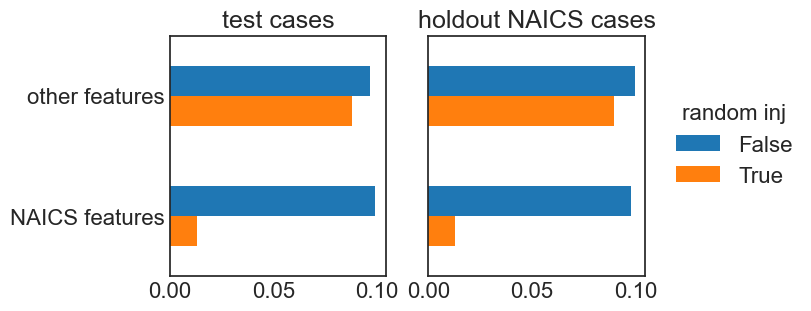

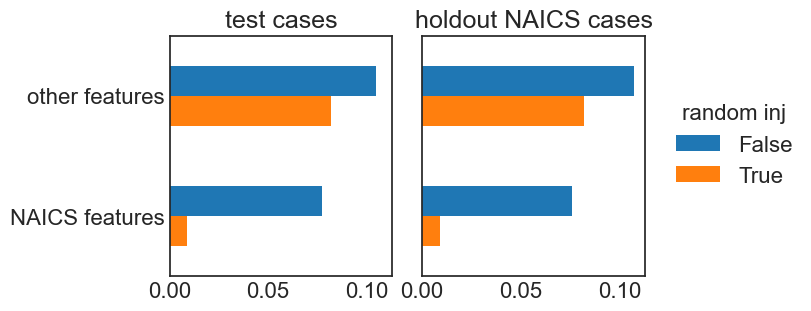

In [44]:
for pair in model_pairs:
    fig, ax=plt.subplots(1, 2, figsize=(8,3),
                        layout='constrained', sharex = True, sharey=True)
    data_1 = data_test[data_test['model'].isin(pair) ]
    
    sbnn_plot.barh_top_n_pair(data_1, columns='rand', x='variable_NAICS',
                    x_order = ['other features','NAICS features'],
                             legend_title='random inj', ax=ax[0],
                             title='test cases')
    data_2 = data_holdout[data_holdout['model'].isin(pair)] 
    ax[0].get_legend().remove()
    sbnn_plot.barh_top_n_pair(data_2, columns='rand', x='variable_NAICS',
                    x_order = ['other features','NAICS features'],
                             legend_title='random inj', ax=ax[1],
                             title='holdout NAICS cases')
    ax[1].legend(bbox_to_anchor=(1.05, 0.8), title='random inj')
    fig.savefig(output_shap_path.joinpath('A21_PLOT_nulled_imp_' + '_'.join(pair) + '.png'))